# [XAI(Explainable Artificial Intelligence)](https://iancovert.com/blog/understanding-shap-sage/)
> XAI는 설명 가능한 인공지능의 약자로, 인공지능의 행위와 도출한 결과를 사람이 이해할 수 있는 형태로 설명하는 방법론과 분야를 일컫는다.    
> 흔히 인공지능 기술은 복잡한 일련의 과정을 통해 결론을 도출하나, 그 과정을 설명할 수 없는 블랙박스로 여겨진다. XAI는 이에 반하는 개념으로 인공지능의 불확실성을 해소하고 신뢰성을 높이는 역할을 하여, 최근 연구가 활발하게 이루어지는 분야이다.

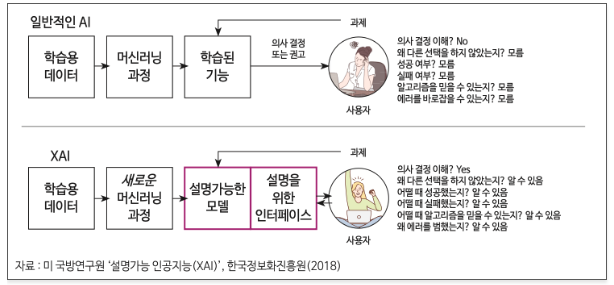

적용 사례

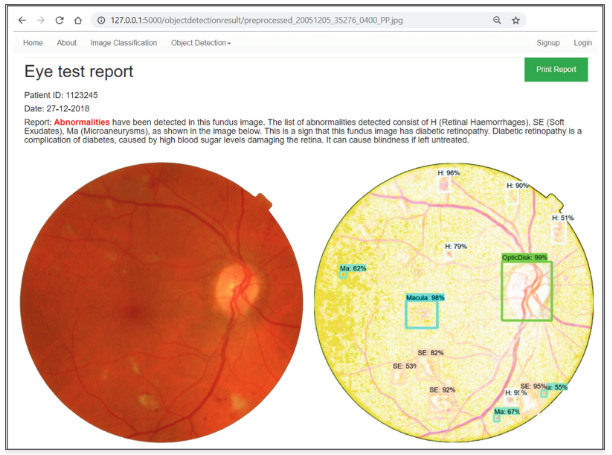

## SHAP vs SAGE

- SHAP
> how much does each feature contribute to this individual prediction?  
> 각 피쳐들이 개별 예측에 얼마나 기여를 하였는지?
- SAGE
> how much does the model depend on each feature overall?    
> 모델 학습시 각 피쳐들에 얼마나 의존하였는가?

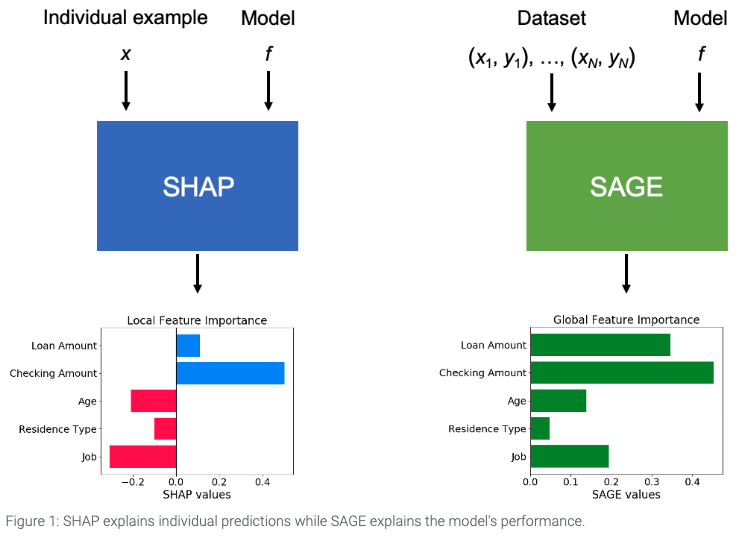

## 데이터 준비

### 데이터 로드

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

df = sns.load_dataset('titanic') # 타이타닉 데이터 받아오기
cols = ["age","sibsp","parch","fare"] # 숫자니까 바로 사용
features = df[cols] # 피쳐
target = df["survived"] # 정답값

### 인코딩

In [2]:
from sklearn.preprocessing import OneHotEncoder

cols = ["pclass","sex","embarked"] # 범주형

enc = OneHotEncoder(handle_unknown='ignore')
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

features = pd.concat([features,tmp],axis=1)

In [3]:
features.head()

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,embarked_nan
0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,35.0,1,0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


### 결측치 제거

In [4]:
features.age = features.age.fillna(features.age.median())

### 데이터 스케일링

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features = pd.DataFrame(
    scaler.fit_transform(features),
    columns = features.columns
)

### 데이터 분리

In [6]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

random_state=42

X_tr, X_te, y_tr, y_te = train_test_split(
    features, target, test_size=0.20,
    random_state=random_state)

X_tr.shape, X_te.shape

((712, 13), (179, 13))

## SAGE(Shapley Additive Global importancE)

### 학습

In [7]:
from lightgbm import LGBMClassifier, plot_importance

model = LGBMClassifier(random_state = random_state).fit(X_tr,y_tr)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

### 평가

In [8]:
from sklearn.metrics import roc_auc_score

pred = model.predict_proba(X_te)[:,1]
roc_auc_score(y_te, pred)

0.8821106821106821

### 중요 파리미터 확인

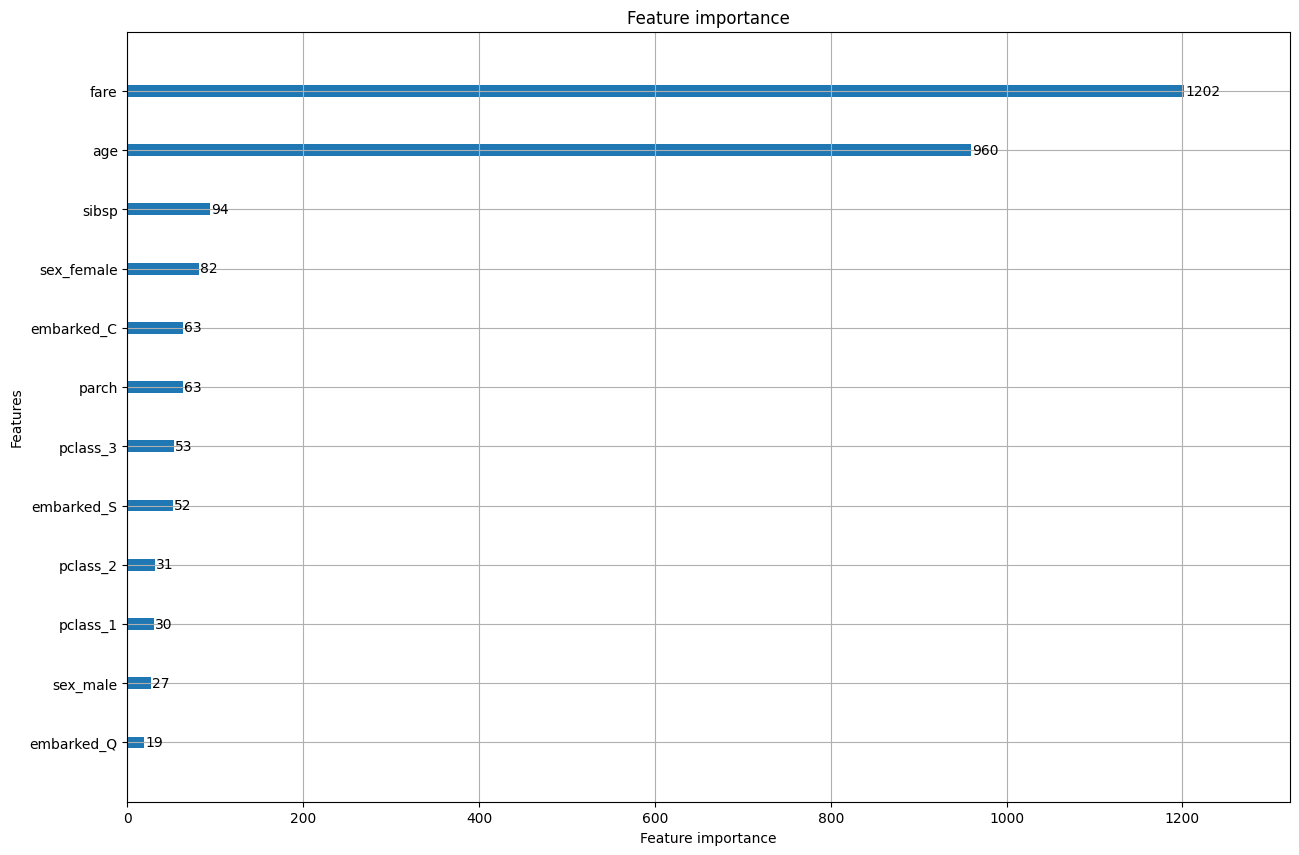

In [9]:
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(figsize = (15,10))
plot_importance(model,ax=ax)
plt.show()

## [SHAP(Shapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/index.html)
- Shapley Value와 피쳐간 독립성을 핵심 아이디어로 사용하는 기법
- Shapley Value는 게임 이론을 바탕으로 각 피쳐의 기여도를 계산하는 방법
- SHAP의 목적은 예측에 대한 각 피쳐의 기여도를 계산하여 관측치(X) 의 예측값을 설명 하는것

In [10]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 26.6 MB/s eta 0:00:00


In [11]:
!pip install scikit-image

In [12]:
import shap
import skimage

In [13]:
# 학습된 모델을 넣는다.
explainer = shap.TreeExplainer(model)
# 학습된 모델을 갖고 X_te를 예측
shap_values = explainer.shap_values(X_te)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [14]:
shap_values[1].shape , X_te.shape

((13,), (179, 13))

### force_plot
- 각 데이터마다 feature의 영향력을 보여줍니다.
- 빨간색은 긍정적인 영향, 파란색은 부정적인 영향

In [15]:
# 첫번째 데이터만 분석
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[0,:],X_te.iloc[0,:])

In [16]:
# 두번째 데이터만 분석
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[1,:],X_te.iloc[1,:])

In [17]:
# 전체 데이터 분석
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_te)

### summary_plot
- force_plot의 전체 데이터의 영향력을 간단하게 시각화하여 보여줌
- `sex_female`은 `target`과 양의 상관관계를 `pclass_3`는 `target`과 음의 상관관계를 나타낸다고 해석할 수 있음

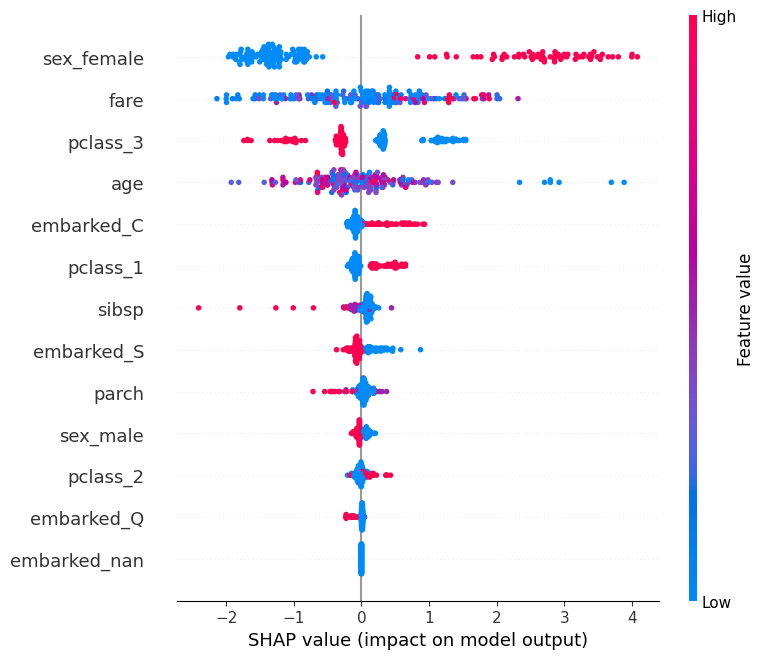

In [18]:
shap.summary_plot(shap_values, X_te)

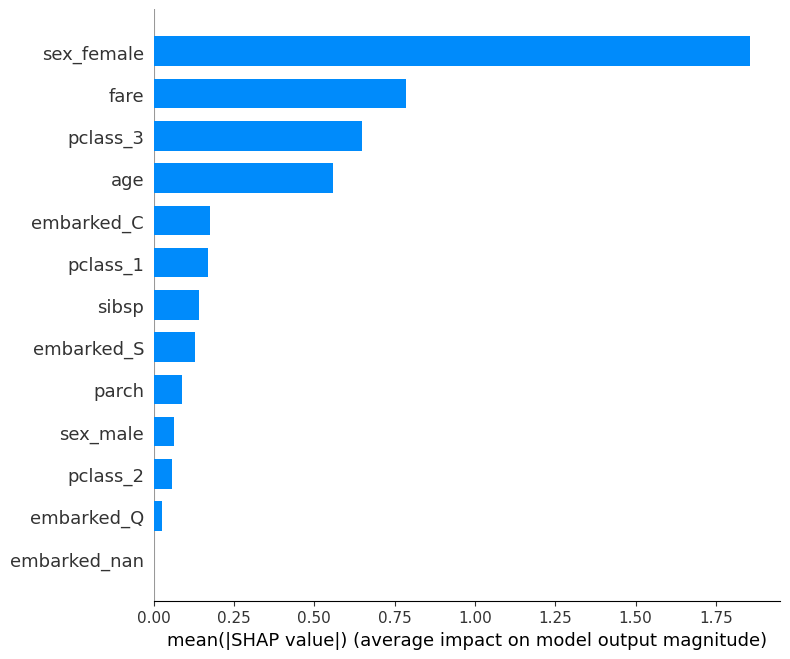

In [19]:
shap.summary_plot(shap_values,X_te, plot_type="bar")

### dependence_plot
- 특정 변수에 대한 영향도 파악

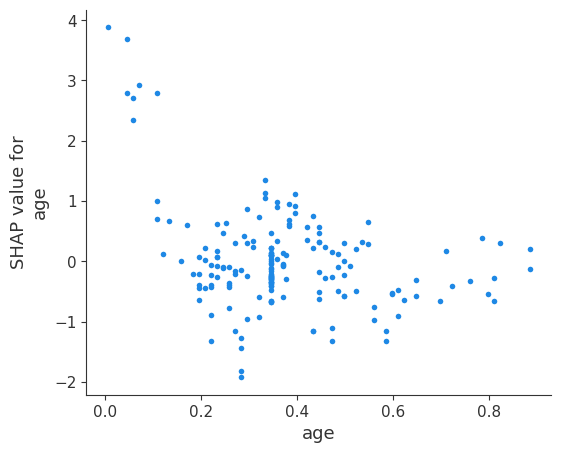

In [20]:
shap.dependence_plot("age", shap_values, X_te,interaction_index=None)

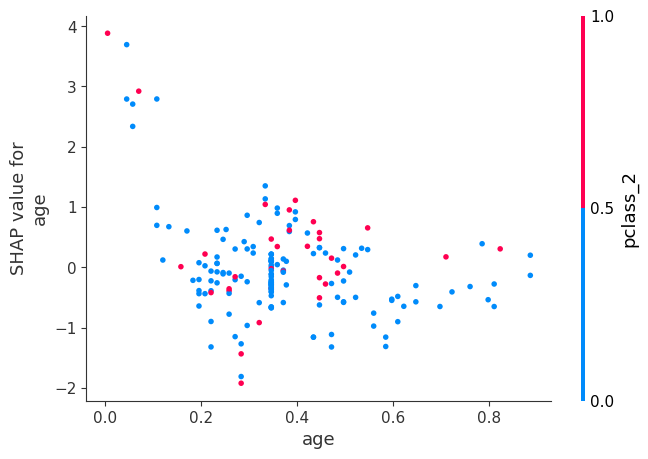

In [21]:
shap.dependence_plot("age", shap_values, X_te,interaction_index="auto")

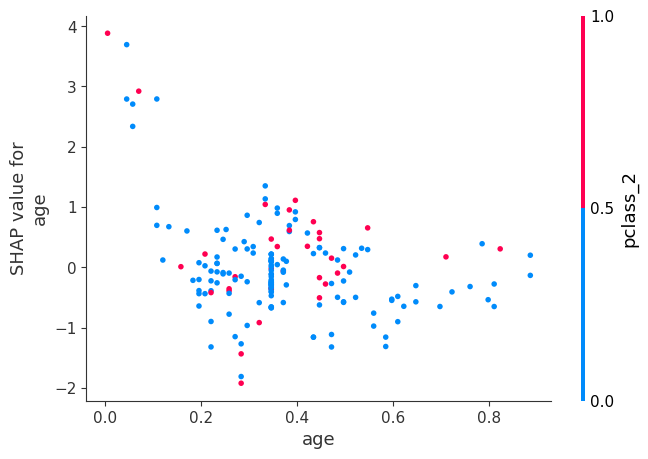

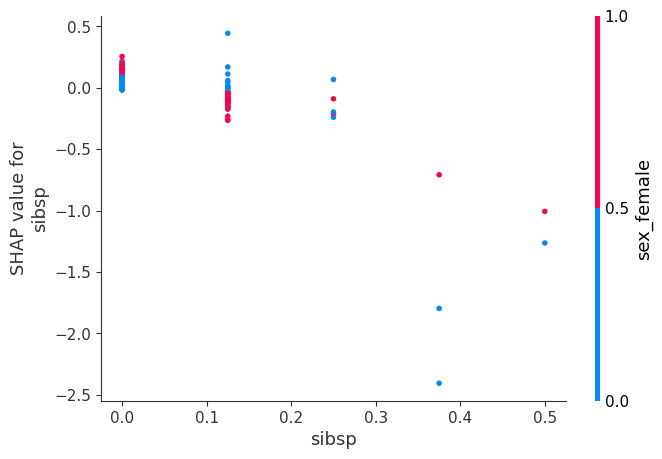

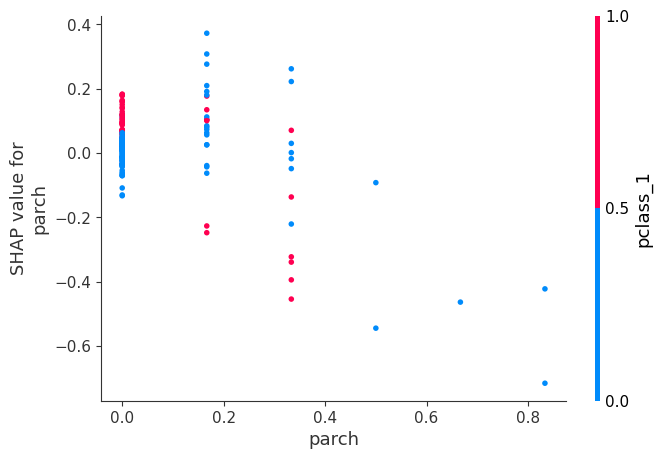

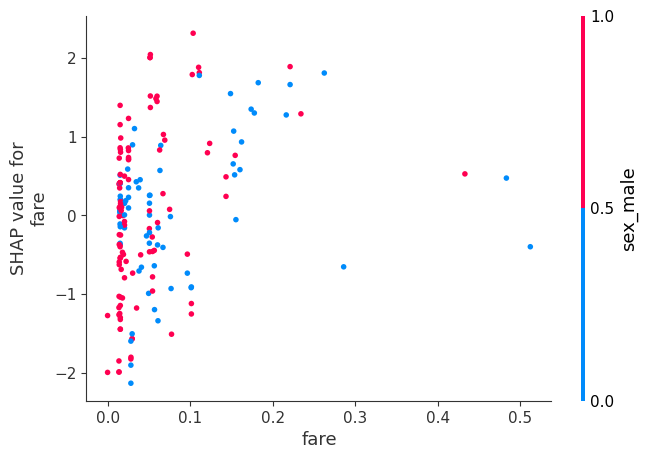

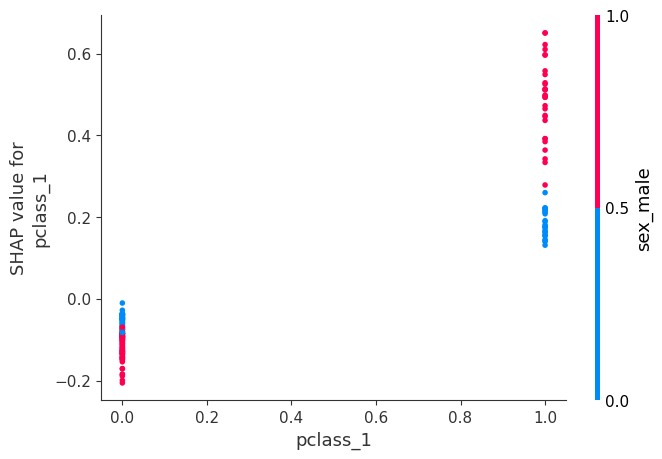

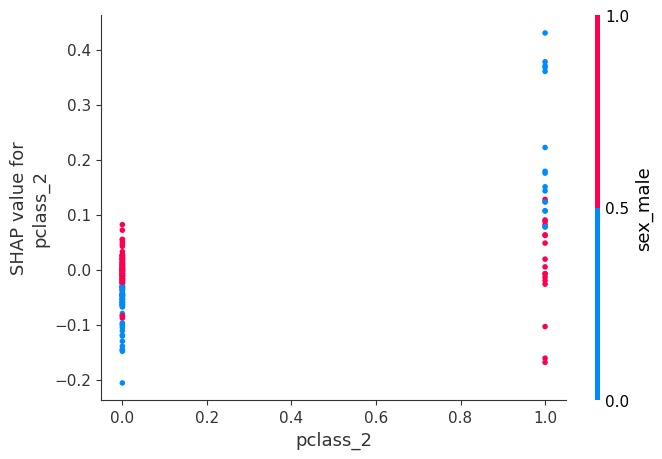

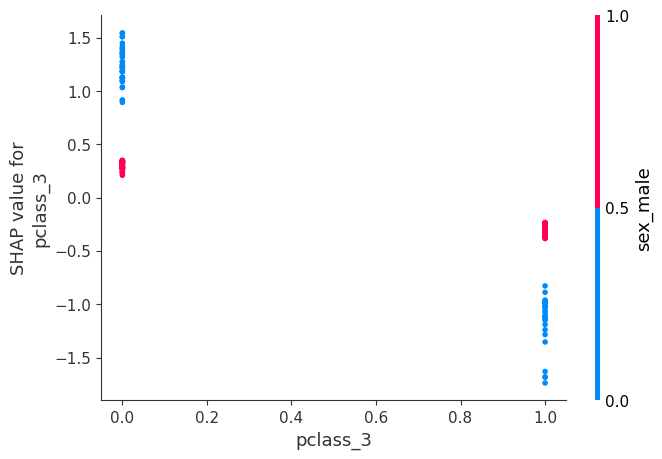

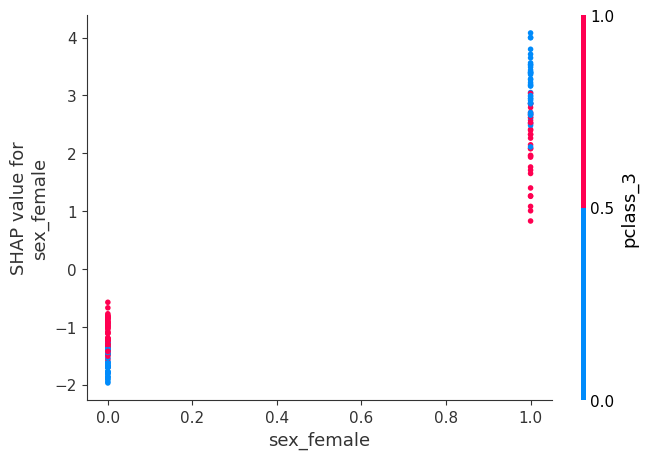

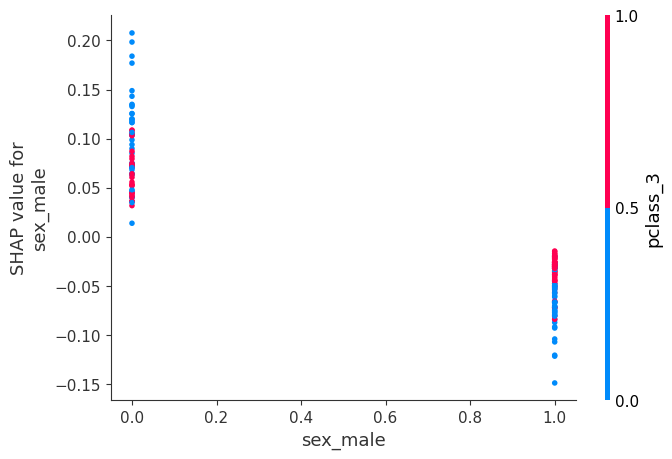

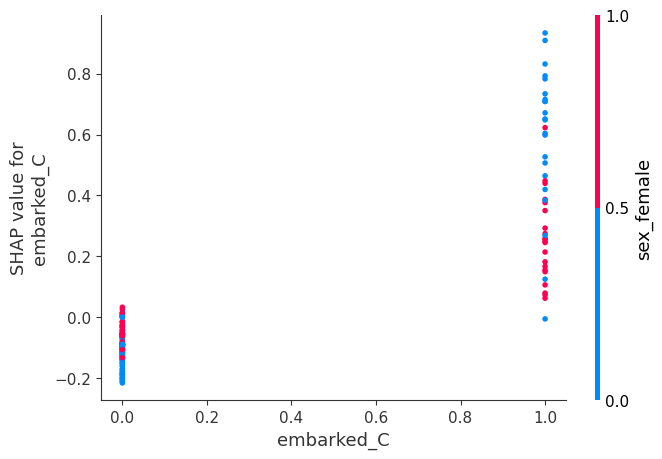

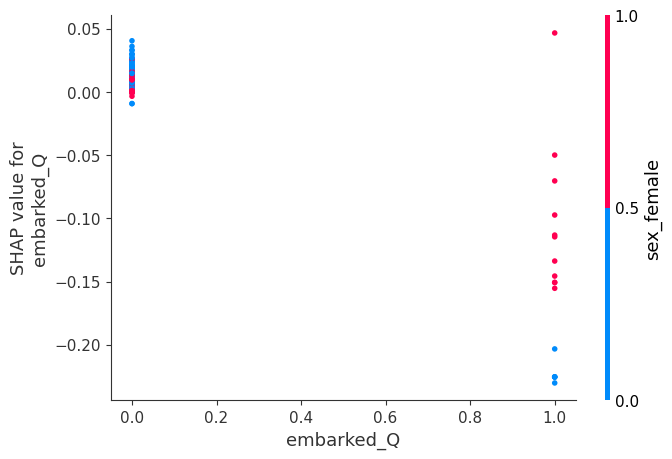

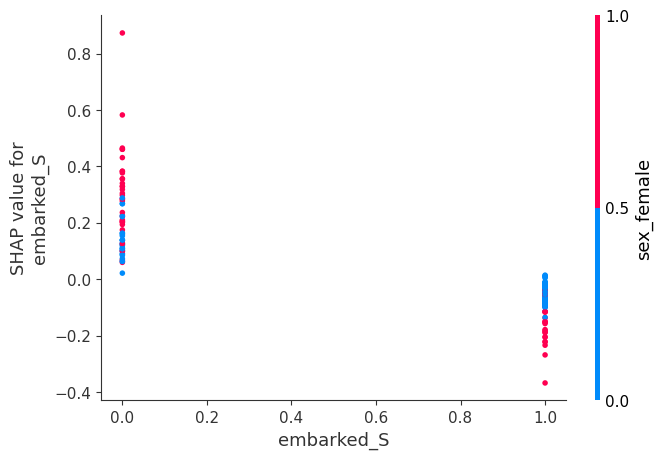

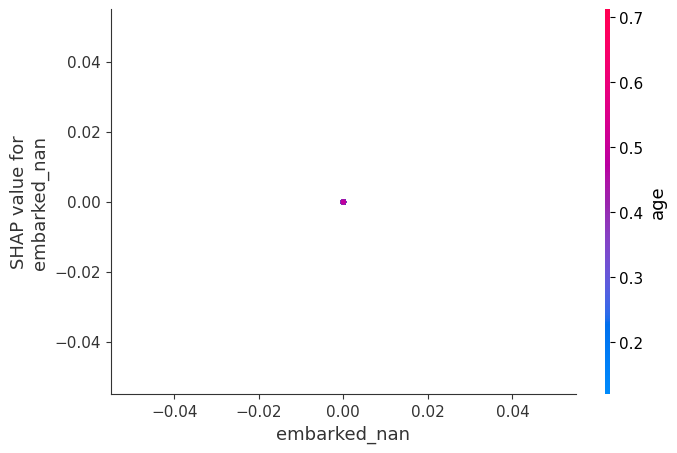

In [22]:
for col in X_te.columns:
    shap.dependence_plot(col, shap_values, X_te)